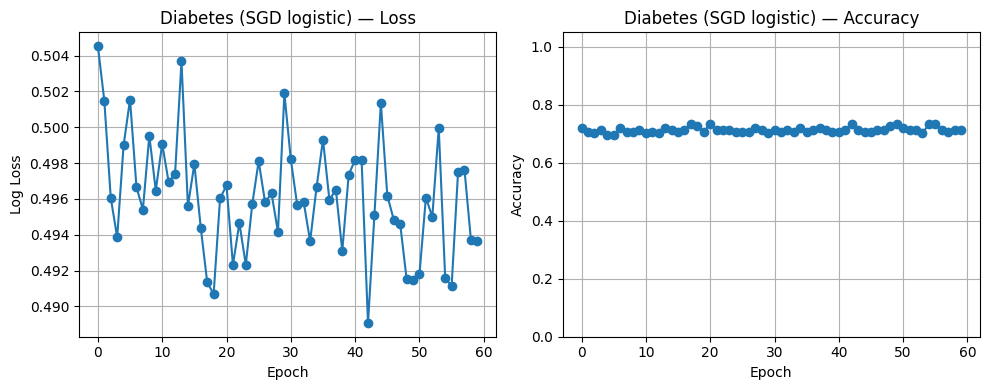


Diabetes — Logistic Regression (Test)
-------------------------------------
Accuracy : 0.7143
Precision: 0.6087
Recall   : 0.5185
F1 Score : 0.5600


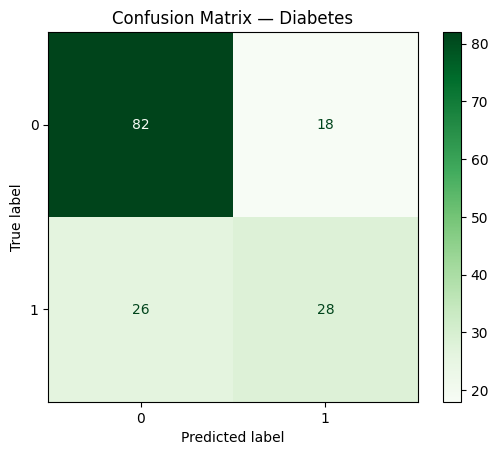

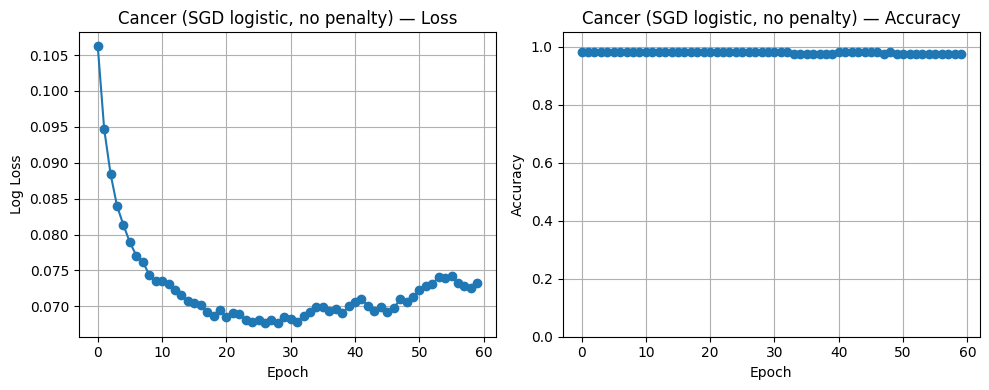


Cancer — Logistic Regression (no penalty)
-----------------------------------------
Accuracy : 0.9649
Precision: 0.9750
Recall   : 0.9286
F1 Score : 0.9512


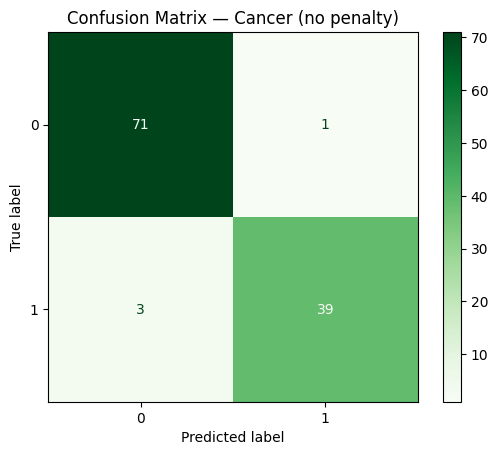

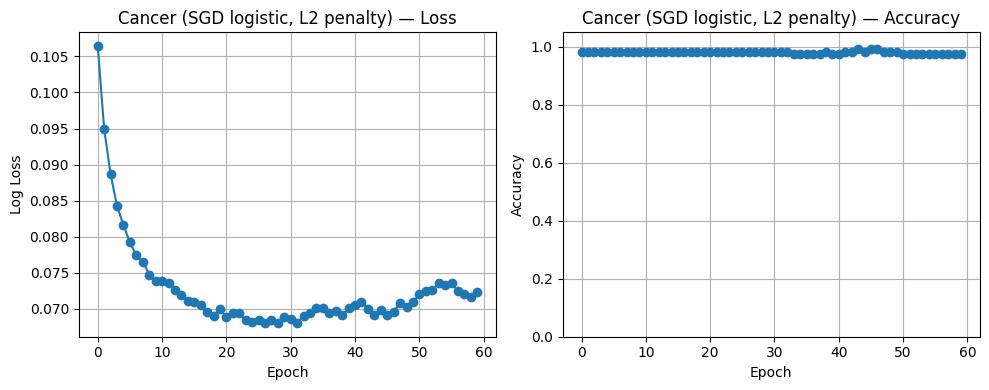


Cancer — Logistic Regression (L2 penalty)
-----------------------------------------
Accuracy : 0.9825
Precision: 1.0000
Recall   : 0.9524
F1 Score : 0.9756


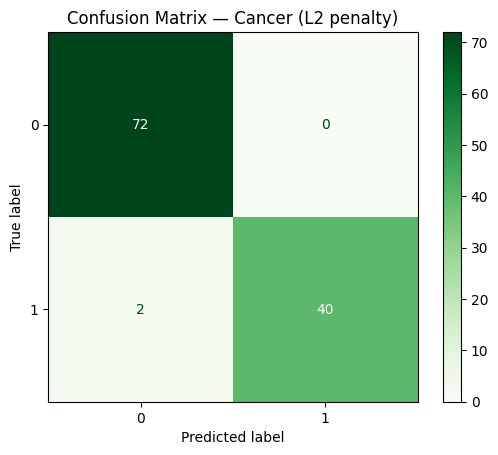

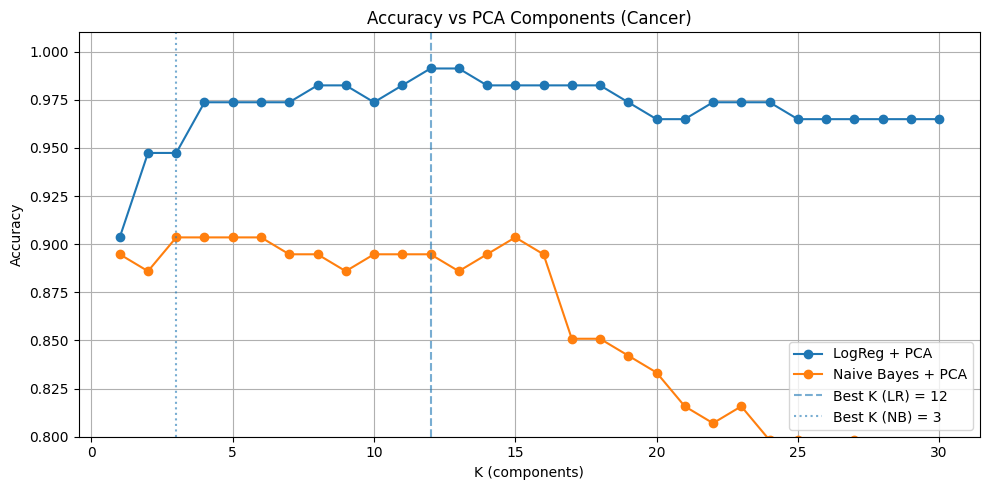


Best PCA K (LR): 12 with accuracy 0.9912
Best PCA K (NB): 3 with accuracy 0.9035
Baseline (2a, LR no penalty) accuracy: 0.9649
L2 model (2b) accuracy              : 0.9825
PCA (LR best-K) vs baselines: 0.9912 >=? 0.9649 / 0.9825


In [5]:
# ============================================================
# HW3 — Final, Correct Code (Colab-ready)
# Satisfies: loss+accuracy curves, initial & penalized models,
# confusion matrices, PCA optimal K identification, comparisons.
# ============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn import datasets
dataset = datasets. load_breast_cancer()
X = dataset.data
Y = dataset. target
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss)
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

RANDOM_STATE = 42
EPOCHS = 60
LR = 0.01

# ---------- helpers ----------
def plot_training_curves(loss_hist, acc_hist, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(loss_hist, marker='o'); plt.title(f'{title} — Loss'); plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.grid(True)
    plt.subplot(1,2,2); plt.plot(acc_hist, marker='o');  plt.title(f'{title} — Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.ylim(0,1.05); plt.grid(True)
    plt.tight_layout(); plt.show()

def report_metrics(y_true, y_pred, title):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f'\n{title}\n' + '-'*len(title))
    print(f'Accuracy : {acc:.4f}\nPrecision: {prec:.4f}\nRecall   : {rec:.4f}\nF1 Score : {f1:.4f}')
    return acc, prec, rec, f1

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Greens'); plt.title(title); plt.show()

def sgd_curves(X_train, y_train, X_val, y_val, alpha=0.0003, l1_ratio=0.0, label=''):
    clf = SGDClassifier(loss='log_loss',
                        penalty='l2' if l1_ratio == 0 else 'elasticnet',
                        alpha=alpha, l1_ratio=l1_ratio,
                        learning_rate='constant', eta0=LR,
                        random_state=RANDOM_STATE)
    classes = np.unique(y_train)
    clf.partial_fit(X_train, y_train, classes=classes)

    loss_hist, acc_hist = [], []
    for epoch in range(EPOCHS):
        idx = np.random.RandomState(RANDOM_STATE + epoch).permutation(len(y_train))
        X_e, y_e = X_train[idx], y_train[idx]
        clf.partial_fit(X_e, y_e)
        y_prob = clf.predict_proba(X_val)
        loss_hist.append(log_loss(y_val, y_prob, labels=[0,1]))
        acc_hist.append(accuracy_score(y_val, (y_prob[:,1]>=0.5).astype(int)))
    return clf, loss_hist, acc_hist

# ============================================================
# Problem 1 — DIABETES
# ============================================================
diab = pd.read_csv('/content/diabetes.csv')
X_d = diab.drop('Outcome', axis=1).values
y_d = diab['Outcome'].values

Xd_tr, Xd_te, yd_tr, yd_te = train_test_split(X_d, y_d, test_size=0.2, stratify=y_d, random_state=RANDOM_STATE)
sc_d = StandardScaler()
Xd_tr_s = sc_d.fit_transform(Xd_tr); Xd_te_s = sc_d.transform(Xd_te)

# curves with SGD
_, d_loss, d_acc = sgd_curves(Xd_tr_s, yd_tr, Xd_te_s, yd_te, alpha=0.0005, label='Diabetes')
plot_training_curves(d_loss, d_acc, 'Diabetes (SGD logistic)')

# final metrics with LogisticRegression
d_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
d_lr.fit(Xd_tr_s, yd_tr)
yd_pred = d_lr.predict(Xd_te_s)

report_metrics(yd_te, yd_pred, 'Diabetes — Logistic Regression (Test)')
plot_confusion(yd_te, yd_pred, 'Confusion Matrix — Diabetes')

# ============================================================
# Problem 2a — CANCER (no penalty)
# ============================================================
# (NEW) use scikit-learn's built-in breast cancer dataset
from sklearn import datasets
dataset = datasets.load_breast_cancer()

# Features and target
X_c = dataset.data            # shape: (n_samples, 30)
y_c_raw = dataset.target      # 0 = malignant, 1 = benign (scikit-learn convention)

# Keep your “positive = malignant” convention (like your CSV mapping 'M'->1):
y_c = (y_c_raw == 0).astype(int)   # now: 1 = malignant, 0 = benign
# (Everything below—train/test split, scaling, SGD curves, LR fits, confusion matrices, PCA—stays unchanged.)


Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(X_c, y_c, test_size=0.2, stratify=y_c, random_state=RANDOM_STATE)
sc_c = StandardScaler()
Xc_tr_s = sc_c.fit_transform(Xc_tr); Xc_te_s = sc_c.transform(Xc_te)

# curves (no penalty)
_, c_loss, c_acc = sgd_curves(Xc_tr_s, yc_tr, Xc_te_s, yc_te, alpha=0.0001, label='Cancer no-penalty')
plot_training_curves(c_loss, c_acc, 'Cancer (SGD logistic, no penalty)')

# final metrics (no penalty)
c_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
c_lr.fit(Xc_tr_s, yc_tr)
yc_pred = c_lr.predict(Xc_te_s)

report_metrics(yc_te, yc_pred, 'Cancer — Logistic Regression (no penalty)')
plot_confusion(yc_te, yc_pred, 'Confusion Matrix — Cancer (no penalty)')

# ============================================================
# Problem 2b — CANCER (with L2 penalty)
# ============================================================
# curves with L2 via SGD (higher alpha => stronger L2)
_, c_l2_loss, c_l2_acc = sgd_curves(Xc_tr_s, yc_tr, Xc_te_s, yc_te, alpha=0.0005, label='Cancer L2')
plot_training_curves(c_l2_loss, c_l2_acc, 'Cancer (SGD logistic, L2 penalty)')

# final metrics with LogisticRegression + stronger L2 (C small)
c_lr_l2 = LogisticRegression(max_iter=1000, C=0.1, random_state=RANDOM_STATE)
c_lr_l2.fit(Xc_tr_s, yc_tr)
yc_pred_l2 = c_lr_l2.predict(Xc_te_s)

report_metrics(yc_te, yc_pred_l2, 'Cancer — Logistic Regression (L2 penalty)')
plot_confusion(yc_te, yc_pred_l2, 'Confusion Matrix — Cancer (L2 penalty)')

# ============================================================
# PCA SWEEPS — identify optimal K and compare to 2a/2b
# (logistic + naive bayes, using standardized cancer features)
# ============================================================
k_vals = range(1, Xc_tr_s.shape[1]+1)
acc_lr_k, acc_nb_k = [], []

for k in k_vals:
    pca = PCA(n_components=k, random_state=RANDOM_STATE)
    Xtr_k = pca.fit_transform(Xc_tr_s); Xte_k = pca.transform(Xc_te_s)

    # LR
    lr_k = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    lr_k.fit(Xtr_k, yc_tr)
    acc_lr_k.append(accuracy_score(yc_te, lr_k.predict(Xte_k)))

    # NB
    nb_k = GaussianNB()
    nb_k.fit(Xtr_k, yc_tr)
    acc_nb_k.append(accuracy_score(yc_te, nb_k.predict(Xte_k)))

# pick optimal Ks
best_k_lr = int(k_vals[np.argmax(acc_lr_k)])
best_k_nb = int(k_vals[np.argmax(acc_nb_k)])
best_acc_lr = max(acc_lr_k); best_acc_nb = max(acc_nb_k)

plt.figure(figsize=(10,5))
plt.plot(k_vals, acc_lr_k, marker='o', label='LogReg + PCA')
plt.plot(k_vals, acc_nb_k, marker='o', label='Naive Bayes + PCA')
plt.axvline(best_k_lr, ls='--', alpha=0.6, label=f'Best K (LR) = {best_k_lr}')
plt.axvline(best_k_nb, ls=':',  alpha=0.6, label=f'Best K (NB) = {best_k_nb}')
plt.title('Accuracy vs PCA Components (Cancer)')
plt.xlabel('K (components)'); plt.ylabel('Accuracy'); plt.ylim(0.8,1.01); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

print(f"\nBest PCA K (LR): {best_k_lr} with accuracy {best_acc_lr:.4f}")
print(f"Best PCA K (NB): {best_k_nb} with accuracy {best_acc_nb:.4f}")

# compare with 2a and 2b LR results:
acc_2a = accuracy_score(yc_te, yc_pred)
acc_2b = accuracy_score(yc_te, yc_pred_l2)
print(f"Baseline (2a, LR no penalty) accuracy: {acc_2a:.4f}")
print(f"L2 model (2b) accuracy              : {acc_2b:.4f}")
print("PCA (LR best-K) vs baselines:", f"{best_acc_lr:.4f}", ">=?" , f"{acc_2a:.4f}", "/", f"{acc_2b:.4f}")
